## 数据处理

In [46]:
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from sklearn.linear_model import LinearRegression

### 行情数据读取

In [47]:
# 读取指数行情数据
path = '/Users/ryan/Desktop/quantchina/leadlag/Empirical/Intraday/data_5min'
file_name = '399633XSHE_5min.csv'
input_file = os.path.join(path,file_name)
df_index = pd.read_csv(input_file)
df_index.columns = ['order','date','open','close']
df_index.insert(0,'Idxcd','000300')
df_index.head(3)

,Idxcd,order,date,open,close
0,000300,0,2021-11-24 14:25:00,6603.40,6597.55
1,000300,1,2021-11-24 14:30:00,6597.17,6598.17
2,000300,2,2021-11-24 14:35:00,6598.69,6600.83


In [48]:
# 读取股票行情数据
path = '/Users/ryan/Desktop/quantchina/leadlag/Empirical/Intraday/data_5min'
file_name = '801161_5min.csv'
read_file = os.path.join(path, file_name)
df = pd.read_csv(read_file)
df.columns = ['Stkcd', 'order', 'date', 'open', 'close']
df.head(3)

,Stkcd,order,date,open,close
0,605011.XSHG,0,2021-11-24 14:25:00,24.63,24.58
1,605011.XSHG,1,2021-11-24 14:30:00,24.60,24.65
2,605011.XSHG,2,2021-11-24 14:35:00,24.63,24.61


In [49]:
# 更换表头
df_index['idx_return'] = (df_index['open']-df_index['close'])/df_index['open']
df_index.set_index('order', inplace=True)
df_index = df_index[['Idxcd', 'date', 'idx_return']]

df['Stkcd'] = df['Stkcd'].str.split('.').apply(lambda x: x[0])
df['stk_return'] = (df['open']-df['close'])/df['open']
df.set_index('order', inplace=True)

In [50]:
df_index.head(3)

,Idxcd,date,idx_return
order,,,
0,000300,2021-11-24 14:25:00,0.000886
1,000300,2021-11-24 14:30:00,-0.000152
2,000300,2021-11-24 14:35:00,-0.000324


In [51]:
df.head(3)

,Stkcd,date,open,close,stk_return
order,,,,,
0,605011,2021-11-24 14:25:00,24.63,24.58,0.002030
1,605011,2021-11-24 14:30:00,24.60,24.65,-0.002033
2,605011,2021-11-24 14:35:00,24.63,24.61,0.000812


### 市值数据处理
读取市值数据并使其与行情数据进行合并

In [52]:
# 读取市值数据
df_size = pd.read_csv('TRD_Dalyr.csv')
df_size.columns = ['Stkcd','trading_date','Size']
df_size

,Stkcd,trading_date,Size
0,1,2021-10-08,3.617263e+08
1,1,2021-10-11,3.764748e+08
2,1,2021-10-12,3.755045e+08
3,1,2021-10-13,3.799679e+08
4,1,2021-10-14,3.727877e+08
...,...,...,...
657686,900957,2022-04-25,1.769430e+05
657687,900957,2022-04-26,1.717080e+05
657688,900957,2022-04-27,1.738020e+05
657689,900957,2022-04-28,1.713590e+05


In [53]:
# 合并行情数据与市值数据
df1 = df.copy()
df1['trading_date'] = df1['date'].str.split(' ').apply(lambda x: x[0])
df1['Stkcd'] = df1['Stkcd'].astype(np.int64)
df1 = pd.merge(df1, df_size, on=['Stkcd','trading_date'], how='left')
df1.tail(3)

,Stkcd,date,open,close,stk_return,trading_date,Size
462293,600483,2022-04-29 14:50:00,12.54,12.66,-0.009569,2022-04-29,24705470.19
462294,600483,2022-04-29 14:55:00,12.66,12.64,0.001580,2022-04-29,24705470.19
462295,600483,2022-04-29 15:00:00,12.64,12.64,0.000000,2022-04-29,24705470.19


In [54]:
df = df1[['Stkcd','date','trading_date','stk_return','Size']]
df.head(3)

,Stkcd,date,trading_date,stk_return,Size
0,605011,2021-11-24 14:25:00,2021-11-24,0.002030,9854463.0
1,605011,2021-11-24 14:30:00,2021-11-24,-0.002033,9854463.0
2,605011,2021-11-24 14:35:00,2021-11-24,0.000812,9854463.0


In [55]:
# 合并指数行情数据与个股行情数据（便于比较）
df2 = df.copy()
df2 = pd.merge(df2, df_index, on='date', how='left')
df = df2[['Stkcd','date','trading_date','stk_return','Size','idx_return']]
df.head(3)

,Stkcd,date,trading_date,stk_return,Size,idx_return
0,605011,2021-11-24 14:25:00,2021-11-24,0.002030,9854463.0,0.000886
1,605011,2021-11-24 14:30:00,2021-11-24,-0.002033,9854463.0,-0.000152
2,605011,2021-11-24 14:35:00,2021-11-24,0.000812,9854463.0,-0.000324


In [56]:
df.dropna(inplace=True, how='any')
df.isna().sum()

<ipython-input-56-6d1a30b7f654>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True, how='any')


Stkcd           0
date            0
trading_date    0
stk_return      0
Size            0
idx_return      0
dtype: int64

## 研究验证

### 研究目标1：行业内部的股票相关性
1. 方差$E(X^2)-E(X)^2$
2. 相关系数热力图

### 验证方法1 求方差

In [57]:
minbar_list = df['date'].drop_duplicates().tolist()
minbar_list.sort()

In [58]:
# 使用方法1进行验证
var_list = []
for minbar in minbar_list:
    df1 = df[df['date']==minbar]
    fir_moment = df1['idx_return'].mean()
    df1['stk_return^2'] = df1['stk_return'].apply(lambda x: x**2)
    sec_moment = df1['stk_return^2'].mean()
    var = sec_moment-fir_moment**2
    var_list.append(var)

<ipython-input-58-60d98085c2ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['stk_return^2'] = df1['stk_return'].apply(lambda x: x**2)


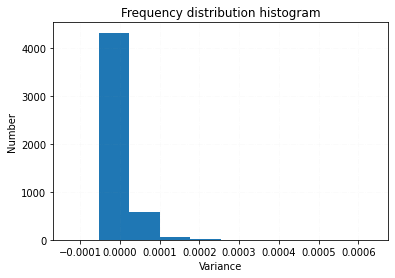

In [59]:
# 数据可视化
def plot_hist(x):
    plt.figure()
    plt.hist(x) 
    plt.grid(alpha=0.05,linestyle='-.')
    plt.xlabel('Variance')  
    plt.ylabel('Number')  
    plt.title(r'Frequency distribution histogram') 
    plt.show()
plot_hist(var_list)

上图呈现的方差情况分布并不是一个合理的情况（虽然很理想），方差过小，即几乎行业内的所有公司在相同时间内收益率没有明显差异       
可能的原因是五分钟能够给股票带来的变化太小（各个股票之间的收益率没有明显差异），导致最终呈现的方差极小        
也有可能是等权指数的变动和行业内公司的变动趋势（和变化程度）相同

接下来的解决办法是降低频率，运用相同的办法进行进一步验证

### 验证方法2 相关系数热力图

In [62]:
stk_list = df['Stkcd'].drop_duplicates().tolist()
corr_list = []

for stk in stk_list:
    inter_list = df[df['Stkcd']==stk]['stk_return'].tolist()
    corr_list.append(inter_list)
corr_list

[[0.0020300446609825707,
  -0.0020325203252031365,
  0.0008120178643929994,
  0.0,
  0.0020300446609825707,
  0.0008136696501220332,
  -0.0012210012210012672,
  -0.001219512195121853,
  -0.006530612244897965,
  -0.005677210056772124,
  0.00362464760370519,
  0.012934518997574647,
  0.0012285012285012749,
  -0.0016406890894176663,
  0.003274662300450196,
  0.0008213552361397587,
  -0.0016433853738701376,
  0.0008203445447087603,
  -0.00041050903119875054,
  0.00041034058268369153,
  -0.00041050903119875054,
  -0.002051702913418166,
  -0.0012285012285011296,
  0.002044989775051154,
  0.0012295081967212125,
  0.0,
  0.0,
  0.0,
  -0.0008206811653672373,
  -0.0012300123001230479,
  0.00040966816878334957,
  0.00040966816878334957,
  0.000819000819000947,
  -0.00327868852459024,
  0.002042483660130748,
  0.0,
  0.0012285012285012749,
  0.0004100041000410645,
  -0.0008206811653672373,
  0.0,
  -0.0020491803278688816,
  0.002045826513911649,
  0.00040983606557368896,
  -0.000410172272354453,


In [63]:
df_corr = DataFrame(corr_list)
df_corr_T = pd.DataFrame(df_corr.values.T)
df_corr_T

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,0.002030,0.002275,0.001176,0.000000,0.000000,0.000000,0.003212,-0.005076,0.000000,-0.002963,...,0.001524,-0.002433,0.000000,0.000000,-0.003922,0.000000,0.001159,0.000000,-0.001779,0.000660
1,-0.002033,0.001139,0.000000,0.000000,0.001229,0.000000,-0.002146,-0.001681,0.000000,0.000000,...,0.001527,-0.002427,0.000000,-0.007722,0.000000,-0.001751,0.001159,-0.001335,0.000000,0.000661
2,0.000812,-0.002283,0.004711,0.001515,0.000000,0.000000,0.005348,0.000000,0.000000,0.000000,...,-0.001529,0.004843,-0.001667,0.000000,0.003906,0.000000,0.000000,-0.001335,0.003552,0.002644
3,0.000000,-0.001138,-0.001186,-0.001520,0.000000,0.000000,-0.001074,0.003356,0.000000,-0.002959,...,0.000000,-0.002433,-0.001667,0.003846,0.000000,-0.001748,0.000000,0.000000,0.000891,0.001988
4,0.002030,0.001136,0.000000,0.001517,0.001232,-0.003460,-0.002146,-0.003367,0.000000,0.002950,...,0.003058,0.000000,-0.001667,0.000000,0.003906,-0.001748,0.000000,0.000000,0.000891,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.000000,-0.001393,-0.002137,0.000000,-0.001475,0.000000,0.002088,-0.002747,-0.001808,-0.002821,...,0.000000,0.000000,0.000000,0.004367,0.003322,-0.003552,NaN,-0.004211,-0.002911,0.000000
4996,-0.000678,0.002786,0.006397,0.000000,0.000000,0.000000,0.000000,-0.001372,-0.001808,0.001408,...,0.002500,0.000000,0.002439,0.000000,-0.003322,0.000000,NaN,-0.002101,-0.002907,0.000797
4997,0.000677,-0.001397,-0.004301,0.001715,-0.001473,-0.003559,-0.002088,0.000000,-0.001808,-0.002821,...,0.000000,-0.003077,0.002439,0.004367,0.003311,0.001761,NaN,0.000000,0.001447,-0.009569
4998,0.001356,0.004184,-0.002141,-0.001721,-0.001473,-0.007117,0.004167,-0.002743,-0.001808,-0.002809,...,-0.002506,0.000000,0.002439,-0.004367,0.003311,-0.007055,NaN,0.000000,-0.004360,0.001580


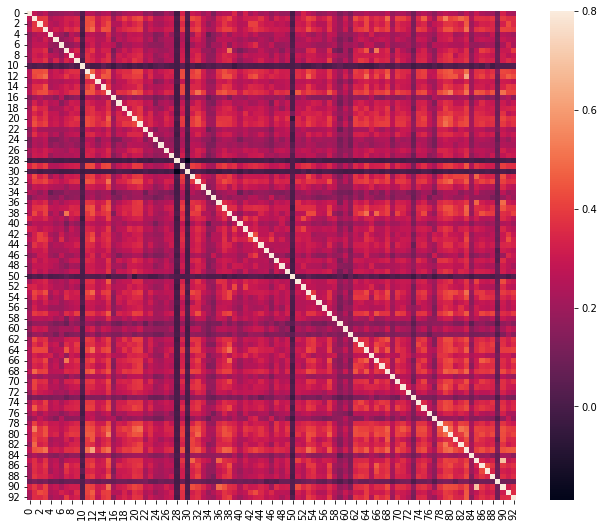

In [64]:
corrmat = df_corr_T.corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

<AxesSubplot:>

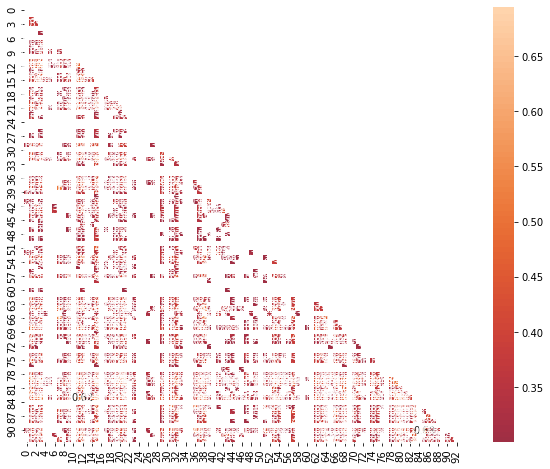

In [65]:
# mask掉上三角 & 小于某个阈值的值
mask1 = np.triu(np.ones_like(corrmat, dtype=bool))
mask2 = np.abs(corrmat) <= 0.3
mask  = mask1 | mask2
 
plt.figure(figsize=(12, 8)) 
sns.heatmap(corrmat,  mask=mask, center=0, annot=True,fmt='.2f', square=True) 